In [1]:
# работа с данными
import pandas as pd
import numpy as np

# графики
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

# настройка графиков
# matplotlib.rcParams['figure.figsize'] = (8, 8)
# sns.set_style('whitegrid')

# предупреждения
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

# tqdm
from tqdm.notebook import tqdm
# time
import itertools

# работа с файлами
import pickle
import json

# copy
from copy import deepcopy

#отображение
from IPython.display import clear_output

In [20]:
train  = pd.read_csv("C:/Users/ranas/ML course/Competitions/Second competition/data/processed/w2v_train.csv")
test = pd.read_csv("C:/Users/ranas/ML course/Competitions/Second competition/data/processed/w2v_test.csv")

In [21]:
train.shape, test.shape

((12500, 201), (12500, 200))

In [4]:
train_target = train['sentiment']
train = train.drop('sentiment', axis=1)

In [5]:
from sklearn.model_selection import train_test_split

tr, val, y_tr, y_val = train_test_split(train, train_target,  
                                    random_state=42, 
                                    test_size=0.25)

tr.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
print(f"train: {tr.shape[0]:,}")
print(f"test: {val.shape[0]:,}")

train: 9,375
test: 3,125


### KNN

In [6]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

param_name = 'n_neighbors'
param_vals = [1, 3, 5, 7, 9, 10, 100, 200, 300, 500, 1000, 2000, 3000, 6000]
metric_vals = []
for param in tqdm(param_vals):
    curr_model = KNeighborsClassifier(**{param_name: param})
    folds_scores = cross_val_score(
        estimator=curr_model,
        X=train,
        y=train_target,
        groups=None,
        scoring='roc_auc',
        cv=KFold(n_splits=5),
        n_jobs=-1,
        verbose=0
    )
    metric_vals.append(folds_scores)
    print(f'param: {param}\tmean roc auc: {round(np.mean(folds_scores), 4)}')

  0%|          | 0/14 [00:00<?, ?it/s]

param: 1	mean roc auc: 0.7423
param: 3	mean roc auc: 0.8313
param: 5	mean roc auc: 0.8578
param: 7	mean roc auc: 0.8691
param: 9	mean roc auc: 0.876
param: 10	mean roc auc: 0.8778
param: 100	mean roc auc: 0.887
param: 200	mean roc auc: 0.8815
param: 300	mean roc auc: 0.8771
param: 500	mean roc auc: 0.8704
param: 1000	mean roc auc: 0.8596
param: 2000	mean roc auc: 0.8452
param: 3000	mean roc auc: 0.8336
param: 6000	mean roc auc: 0.806
Wall time: 41.3 s


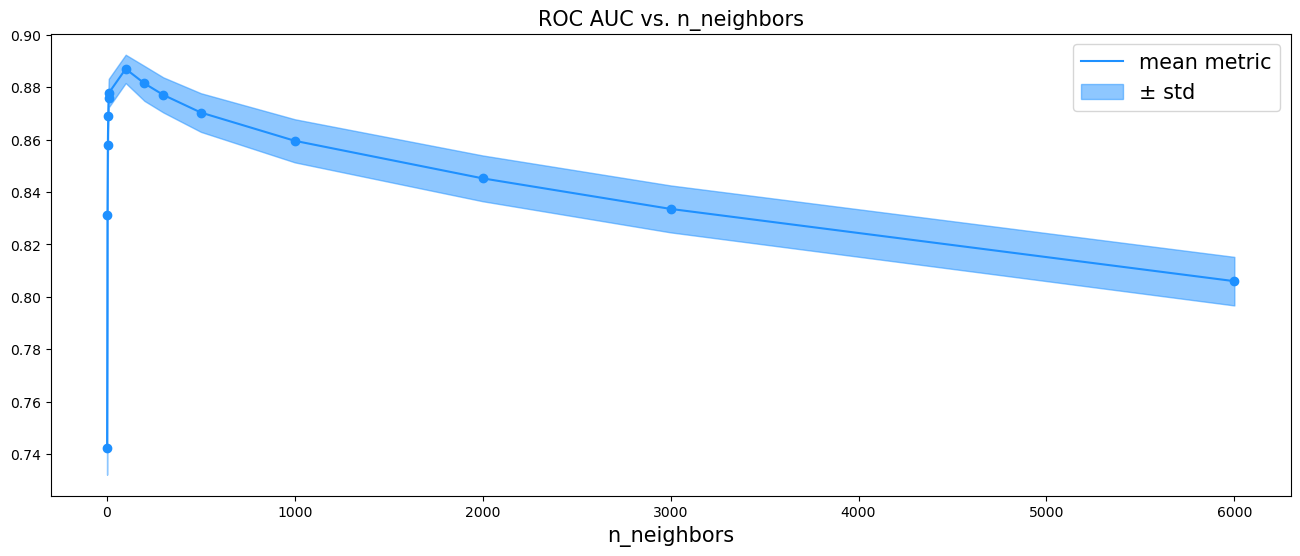

In [7]:
mean_metric = np.array([np.mean(fold_vals) for fold_vals in metric_vals])
std_metric = np.array([np.std(fold_vals) for fold_vals in metric_vals])


plt.figure(figsize=(16, 6))
plt.title(f'ROC AUC vs. {param_name}', fontsize=15);
plt.plot(param_vals, mean_metric, color='dodgerblue', label='mean metric');
plt.scatter(param_vals, mean_metric, color='dodgerblue');
plt.fill_between(param_vals, mean_metric - std_metric, mean_metric + std_metric, color='dodgerblue', alpha=0.5, 
                 label='± std');
plt.xlabel(param_name, fontsize=15);
plt.legend(fontsize=15);

In [8]:
%%time
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=100)
model.fit(tr, y_tr)

Wall time: 8.98 ms


KNeighborsClassifier(n_neighbors=100)

Тут что-то не так

In [13]:
model.predict_proba(tr)[:,1]

array([0.12, 0.21, 0.63, ..., 0.18, 0.21, 0.39])

In [14]:
from sklearn.metrics import roc_auc_score

train_metric = roc_auc_score(
    y_true=y_tr,
    y_score=model.predict_proba(tr)[:,1]
)

val_metric = roc_auc_score(
    y_true=y_val,
    y_score=model.predict_proba(val)[:,1]
)

print(f"train_roc_auc: {round(train_metric, 4)}")
print(f"val_roc_auc: {round(val_metric, 4)}")

train_roc_auc: 0.8909
val_roc_auc: 0.8934


### Random Forest

In [15]:
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier(max_depth=None)
dtr.fit(train, train_target)

DecisionTreeClassifier()

In [16]:
dtr.get_depth(), dtr.get_n_leaves()

(33, 1146)

In [17]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 300)
forest = forest.fit(tr, y_tr)
score = roc_auc_score(y_val, forest.predict_proba(val)[:,1])
print("Training set: %0.5f mean accuracy with a standard deviation of %0.5f" % (np.mean(score), np.std(score)))

Training set: 0.91262 mean accuracy with a standard deviation of 0.00000


Тут надо бы настроить optuna

In [ ]:
# import sys
# sys.path.insert(1, 'C:/Users/ranas/ML course/Competitions/Second competition/functions')

In [ ]:
# import optuna

# from sklearn.ensemble import RandomForestClassifier
# from models_evaluation import cv_score

# def objective(trial):
    
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
#         "criterion": trial.suggest_categorical('criterion', ["gini", "entropy"]),
#         "max_depth": trial.suggest_int("max_depth", 1, 100),
#         "min_samples_split": trial.suggest_int("min_samples_split", 2, 200),
#         "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 500),
#         "max_features": None,
#         "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 700, log=True),
#         "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0, 20)
#     }
    
#     model = RandomForestClassifier(**params, random_state = 33)
        
#     score = cv_score(train, train_target, model, random_state=33) #the rest is set automatically
#     return np.mean(score)

In [ ]:
# %%time
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=300)
# clear_output()

# best_params = study.best_params
# print("best trial:")
# print(study.best_trial, end='\n'*2)
# print("best params:")
# print(best_params, end='\n'*2)

In [ ]:
# model = RandomForestClassifier(**best_params, random_state = 33)

# score = cv_score(train, train_target, model)
# print("Training set: %0.5f mean accuracy with a standard deviation of %0.5f" % (np.mean(score), np.std(score)))

<BarContainer object of 200 artists>

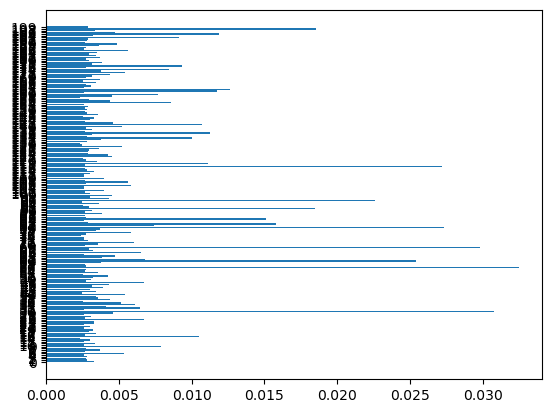

In [18]:
plt.barh(train.columns, forest.feature_importances_)

In [ ]:
#надо поправить, что к данным с тестом подтягивались id

In [22]:
test_for_id = pd.read_csv("C:/Users/ranas/ML course/Competitions/Second competition/data/raw/test.csv")

In [23]:
submission = pd.DataFrame()
submission["id"] = test_for_id["id"]
submission["review"] = forest.predict_proba(test)[:,1]

submission.head()

,id,review
0,d7593a4a9f7bade74d17667e488a6f3e,0.066667
1,2294e3b907d750dcc32c35be503da86a,0.743333
2,43acdaff0a72ab9a365104db9b163f2e,0.096667
3,0b061ac5f9c62e45fe922ee28819b73b,0.746667
4,a80165e5617c4a46a019c4424637f68e,0.066667


In [24]:
submission.to_csv("submission_rf.csv", index=False)

### SVM

### Logistic Regression